In [1]:
import earthpy.spatial as es
import os, sys
from glob import glob
import rasterio as rio
import matplotlib.pyplot as plt
import rasterstats
import geopandas as gpd
import pandas as pd
from rasterio.plot import show, reshape_as_image
import numpy as np
from matplotlib.animation import FuncAnimation

In [2]:
images = glob(os.path.join('./data_collated',"**/*WATER_MASKED.tif"), recursive = True)

images

['./data_collated\\2013\\2013_WATER_MASKED.tif',
 './data_collated\\2014\\2014_WATER_MASKED.tif',
 './data_collated\\2015\\2015_WATER_MASKED.tif',
 './data_collated\\2016\\2016_WATER_MASKED.tif',
 './data_collated\\2017\\2017_WATER_MASKED.tif',
 './data_collated\\2018\\2018_WATER_MASKED.tif',
 './data_collated\\2019\\2019_WATER_MASKED.tif',
 './data_collated\\2020\\2020_WATER_MASKED.tif',
 './data_collated\\2021\\2021_WATER_MASKED.tif',
 './data_collated\\2022\\2022_WATER_MASKED.tif']

In [3]:
ndvi_dict = {}
years = [str(year) for year in range(2013,2023)]

for idx, image in enumerate(images):
    with rio.open(image) as src:
        # import red and nir bands
        nir = src.read(5, masked = True)
        red = src.read(4, masked = True)
    src.close()

    # Adjust to reflectance using the given scale factors; see document below
    # https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat8-9-Collection2-Level2-Science-Product-Guide-v5.pdf
    nir = nir * 0.0000275 + -0.2
    red = red * 0.0000275 + -0.2

    # ndvi calculation
    ndvi = (nir - red) / (nir + red)

    # Landsat 8 Level 2 products have an issue where water can result in negative reflectance
    # in such cases, set NDVI to -1
    ndvi[(nir < 0) | (red < 0)] = -1
    
    # Append raster to dictionary
    ndvi_dict[years[idx]] = ndvi

In [4]:
ndvi_dict

{'2013': masked_array(
   data=[[0.29939189553260803, 0.24800609052181244, 0.25450772047042847,
          ..., 0.8395271897315979, 0.8151180744171143, 0.7120533585548401],
         [0.30951499938964844, 0.32823339104652405, 0.3376455307006836,
          ..., 0.9377093315124512, 0.7714939117431641, 0.5804723501205444],
         [-0.06611891835927963, 0.1955541968345642, 0.3334633708000183,
          ..., -1.0, 0.5747003555297852, 0.400467187166214],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., 0.9763835072517395, 0.9755796194076538,
          0.8857325315475464],
         [--, --, --, ..., -1.0, 0.9768600463867188, 0.6834847331047058]],
   mask=[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ..., False, False, False],
         [ True,

CPU times: total: 15.8 s
Wall time: 15.9 s


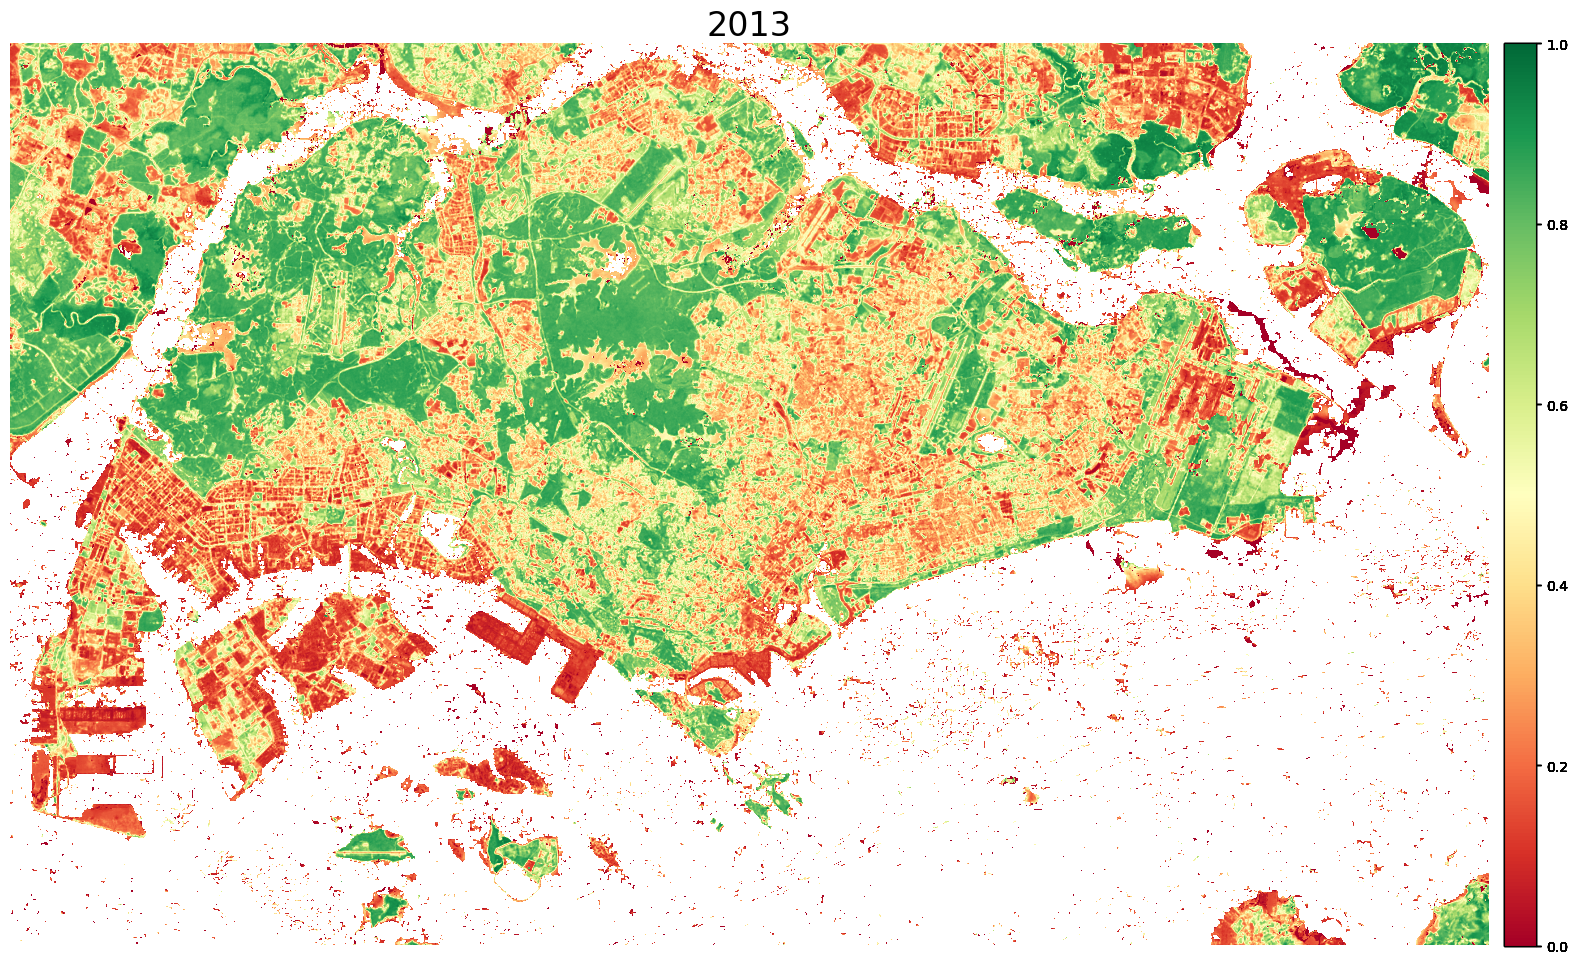

In [58]:
%%time
fig, ax = plt.subplots(figsize = (16,12))
ax.axis("off")

# This creates a colorbar that will stay on the animation
# Adds axes with the following arguments: left bottom width height
# cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

vmin = 0
vmax = 1

# # This creates a colorbar that will stay on the animation
# # Adds axes with the following arguments: left bottom width height
# cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
# sm = plt.cm.ScalarMappable(cmap = "RdYlGn", norm=plt.Normalize(vmin = -0.5, vmax = 1))
# # fake up the array of the scalar mappable. Urgh...
# sm._A = []
# fig.colorbar(sm, cax=cax)

def update(frame):
    year = years[frame]
    
    im = ax.imshow(ndvi_dict[year], cmap = "RdYlGn", vmin = vmin, vmax = vmax)
    
    ax.set_title(f"{year}", fontsize = 24)
    
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    
    fig.colorbar(im, cax=cax)
    
animation = FuncAnimation(fig, update, frames=len(years), repeat=True, interval = 1000)

plt.subplots_adjust(
    top=0.91,
    bottom=0.02,
    left=0.008,
    right=0.932,
    hspace=0.2,
    wspace=0.2
)

# Save the animation
animation_file = f'singapore_ndvi_postmosaic_animation_scaled.gif'
animation.save(animation_file, writer='pillow')

In [12]:
# save the masked ndvi images as rasters:
with rio.open(images[0]) as src:
    profile = src.profile
    src.close()
    
profile.update(count = 1)

for key in ndvi_dict:
    with rio.open(
        f"{key}_NDVI_MASKED.tif",
        "w",
        **profile
    ) as dst:
        dst.write(ndvi_dict[key], 1)
        dst.close()

In [14]:
# import the suburbs_cleaned as geodataframe
sg_suburbs = gpd.read_file("sg_suburbs_cleaned.geojson")

print(sg_suburbs.crs)

sg_suburbs

EPSG:32648


,name,geometry
0,Downtown Core,"POLYGON ((371740.714 142113.685, 371955.834 14..."
1,Bukit Batok,"POLYGON ((362192.747 152536.286, 362055.609 15..."
2,Tengah,"POLYGON ((359614.641 149224.902, 359550.156 14..."
3,Jurong West,"POLYGON ((358509.535 149245.710, 358510.108 14..."
4,Lim Chu Kang,"POLYGON ((359861.582 157191.731, 359814.810 15..."
5,Western Islands,"POLYGON ((350237.497 133640.364, 351984.375 13..."
6,Choa Chu Kang,"POLYGON ((361434.117 153539.246, 361384.832 15..."
7,Western Water Catchment,"POLYGON ((354653.547 158873.396, 352900.666 15..."
8,Tuas,"POLYGON ((350008.856 136826.082, 350237.497 13..."
9,Pioneer,"POLYGON ((352570.408 147159.986, 352518.444 14..."


In [15]:
# get zonal stats for all years
for key in ndvi_dict:
    sg_ndvi = rasterstats.zonal_stats(
        "sg_suburbs_cleaned.geojson",
        f"{key}_NDVI_MASKED.tif",
        # Note that rasterstats automatically runs masked version of the functions
        # Note that add_stats will calculate the added stats in addition to the default stats which 
        # include min, Max, mean, and count
        
        # note that rasterstats automatically runs masked versions of the basic stats
        add_stats = {'masked_mean':np.ma.mean, "masked_median": np.ma.median}
    )
    
    sg_ndvi = pd.DataFrame(sg_ndvi)
    # Add prefix does NOT automatically add an underscore
    sg_ndvi = sg_ndvi.add_prefix(f"{key}_")
    
    sg_suburbs = pd.concat([sg_suburbs, sg_ndvi], axis = 1)
    
sg_suburbs

,name,geometry,2013_min,2013_max,2013_mean,2013_count,2013_masked_mean,2013_masked_median,2014_min,2014_max,...,2021_mean,2021_count,2021_masked_mean,2021_masked_median,2022_min,2022_max,2022_mean,2022_count,2022_masked_mean,2022_masked_median
0,Downtown Core,"POLYGON ((371740.714 142113.685, 371955.834 14...",-1.000000,0.898428,0.334946,4117,0.334946,0.294629,-1.000000,0.995585,...,0.301318,4208,0.301318,0.259810,-1.000000,0.996102,0.325442,4273,0.325442,0.282266
1,Bukit Batok,"POLYGON ((362192.747 152536.286, 362055.609 15...",-0.007714,0.927898,0.579670,12379,0.579670,0.601994,-1.000000,0.993942,...,0.540280,12374,0.540280,0.511876,-1.000000,0.995722,0.579132,12363,0.579132,0.580646
2,Tengah,"POLYGON ((359614.641 149224.902, 359550.156 14...",0.133661,0.920402,0.816487,8268,0.816487,0.855727,-1.000000,0.974043,...,0.577610,8268,0.577610,0.682948,-1.000000,0.998864,0.620706,8265,0.620706,0.773695
3,Jurong West,"POLYGON ((358509.535 149245.710, 358510.108 14...",-1.000000,0.986515,0.454072,16303,0.454072,0.425647,-1.000000,0.994063,...,0.405503,16305,0.405503,0.381446,-1.000000,0.996763,0.413527,15535,0.413527,0.393450
4,Lim Chu Kang,"POLYGON ((359861.582 157191.731, 359814.810 15...",-1.000000,0.987673,0.679910,18167,0.679910,0.751783,-1.000000,0.985705,...,0.636367,18975,0.636367,0.696538,-1.000000,0.971788,0.664237,18913,0.664237,0.734576
5,Western Islands,"POLYGON ((350237.497 133640.364, 351984.375 13...",-1.000000,0.987854,0.327248,48068,0.327248,0.245342,-1.000000,0.999766,...,0.269499,64065,0.269499,0.192575,-1.000000,0.999735,0.346612,57135,0.346612,0.277711
6,Choa Chu Kang,"POLYGON ((361434.117 153539.246, 361384.832 15...",-0.039149,0.896382,0.434798,6772,0.434798,0.422182,-1.000000,0.971068,...,0.418038,6774,0.418038,0.403386,-1.000000,0.978420,0.449415,6770,0.449415,0.426841
7,Western Water Catchment,"POLYGON ((354653.547 158873.396, 352900.666 15...",-1.000000,0.999712,0.707079,73852,0.707079,0.788641,-1.000000,0.999442,...,0.649163,76393,0.649163,0.727672,-1.000000,0.998956,0.678270,74498,0.678270,0.776253
8,Tuas,"POLYGON ((350008.856 136826.082, 350237.497 13...",-1.000000,0.996543,0.331460,32706,0.331460,0.282779,-1.000000,0.997773,...,0.236951,46311,0.236951,0.192399,-1.000000,0.999797,0.277431,47603,0.277431,0.208124
9,Pioneer,"POLYGON ((352570.408 147159.986, 352518.444 14...",-1.000000,0.932177,0.282472,14279,0.282472,0.242695,-1.000000,0.988293,...,0.272394,14779,0.272394,0.249282,-1.000000,0.995491,0.291700,14426,0.291700,0.253541


C:\Users\Jonny\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
C:\Users\Jonny\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
C:\Users\Jonny\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
C:\Users\Jonny\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ver

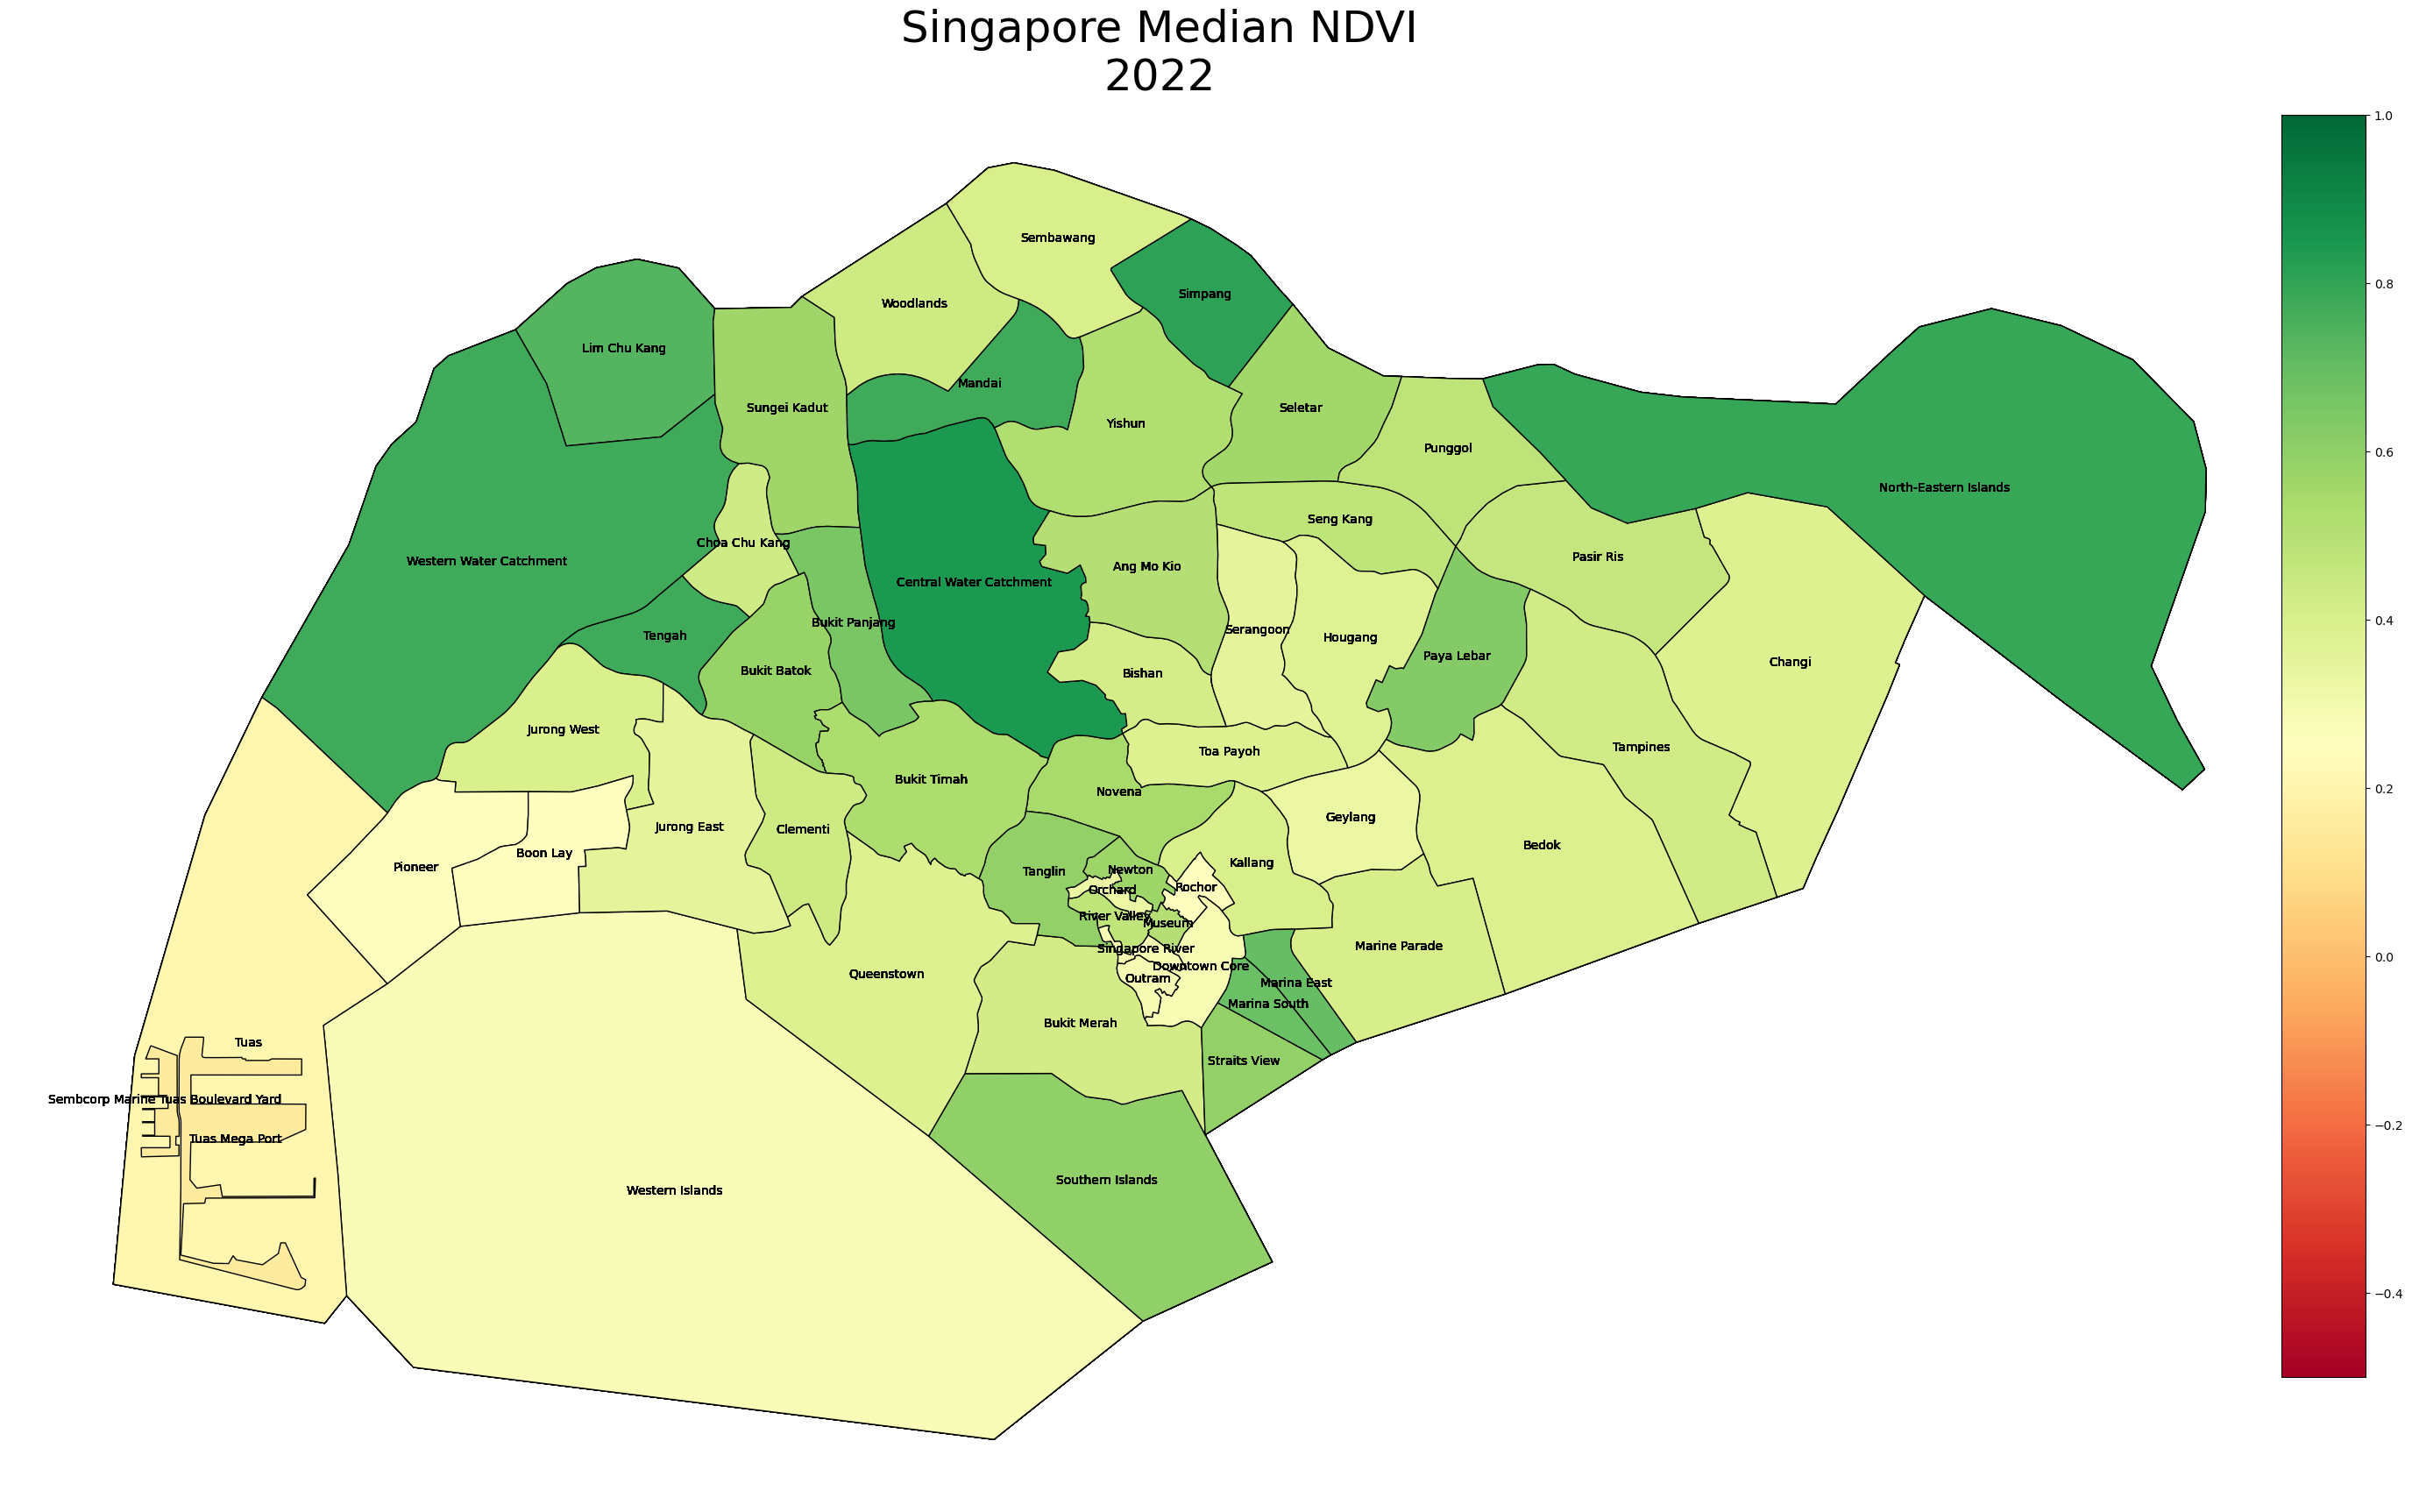

In [17]:
%%time
from matplotlib.animation import FuncAnimation

years = [str(year) for year in range(2013, 2023)]

# %matplotlib qt5
fig, ax = plt.subplots(figsize = (32,18))
ax.axis("off")

ims = []

# Create a custom gradient cmap
# from matplotlib.colors import LinearSegmentedColormap
# cmap = LinearSegmentedColormap.from_list(
#     name='custom',
#     colors=['red', 'yellow', 'green'])

# This creates a colorbar that will stay on the animation
# Adds axes with the following arguments: left bottom width height
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap = "RdYlGn", norm=plt.Normalize(vmin = -0.5, vmax = 1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)


# colorbar = plt.colorbar(ndvi_plot)
def update(frame):
    year = years[frame]
    
    if len(ims) > 0:
        del ims[0]

    # This is apparently how you animate with gpd plot
    artist = sg_suburbs.plot(ax = ax, column = f"{year}_masked_median", edgecolor = "black",
                             cmap = "RdYlGn", vmin = -0.5, vmax = 1)
    
    # Annotate municipality names
    sg_suburbs.apply(lambda x: ax.annotate(text = x["name"], 
                                       xy = x["geometry"].centroid.coords[0],
                                       ha = "center"), axis = 1)
    
    # colorbar = plt.colorbar(artist)
    
    ims.append(artist)
    
    ax.set_title(f"Singapore Median NDVI\n{year}", fontsize = 36)
    
    return ims

# Call the func animation class with the appropriate arguments. Frames indicates how many
# frames there will be IE how many frames will be passed into the `update` function, while
# repeat tells matplotlib whether to loop the animation, interval tells FuncAnimation how much time
# between frames
animation = FuncAnimation(fig, update, frames=len(years), repeat=True, interval = 1000)
plt.subplots_adjust(
    top=0.91,
    bottom=0.02,
    left=0.008,
    right=0.992,
    hspace=0.2,
    wspace=0.2
)

# Save the animation
animation_file = f'singapore_masked_ndvi_animation_by_median.gif'
animation.save(animation_file, writer='pillow')

plt.show()